In [1]:
import os
import torch
import pandas as pd
import scanpy as sc
from sklearn import metrics
import multiprocessing as mp
from GraphST import GraphST
from pathlib import Path

/data/hgh/anaconda3/envs/py310-torch25/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/data/hgh/anaconda3/envs/py310-torch25/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/data/hgh/anaconda3/envs/py310-torch25/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/data/hgh/anaconda3/envs/py310-torch25/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/data/hgh/anaconda3/envs/py310-torch25/lib/python3.10/site-packages/anndata/utils.py:429: 

In [2]:
# adata = sc.read_h5ad('../data/MERFISH/MERFISH_0.09.h5ad')
# adata = sc.read_h5ad('../data/BaristaSeq/Slice_2_removed.h5ad')
adata = sc.read_h5ad('../data/osmfish/osmfish_remove_excluded.h5ad')
print(adata)
adata.var_names_make_unique()

AnnData object with n_obs × n_vars = 4839 × 33
    obs: 'ClusterName', 'ClusterID', 'Region'
    uns: 'ClusterName_colors'
    obsm: 'spatial'


In [3]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
model = GraphST.GraphST(adata, device=device)

# train model
adata = model.train()

/data/hgh/anaconda3/envs/py310-torch25/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:64: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


Begin to train ST data...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 28.30it/s]

Optimization finished for ST data!


In [4]:
adata

AnnData object with n_obs × n_vars = 4839 × 33
    obs: 'ClusterName', 'ClusterID', 'Region'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'ClusterName_colors', 'hvg', 'log1p'
    obsm: 'spatial', 'distance_matrix', 'graph_neigh', 'adj', 'label_CSL', 'feat', 'feat_a', 'emb'

In [5]:
tool = 'louvain' # mclust, leiden, and louvain
radius = 50
n_clusters = len(adata.obs['Region'].unique())
# clustering
from GraphST.utils import clustering
clustering(adata, n_clusters, radius=radius, method=tool, start=0.1, end=2.0, increment=0.01, refinement=False)

Searching resolution...


/data/hgh/anaconda3/envs/py310-torch25/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


resolution=1.989999999999999, cluster number=16
resolution=1.979999999999999, cluster number=16
resolution=1.969999999999999, cluster number=16
resolution=1.959999999999999, cluster number=15
resolution=1.949999999999999, cluster number=15
resolution=1.939999999999999, cluster number=15
resolution=1.9299999999999993, cluster number=15
resolution=1.9199999999999993, cluster number=15
resolution=1.9099999999999993, cluster number=15
resolution=1.8999999999999992, cluster number=16
resolution=1.8899999999999992, cluster number=15
resolution=1.8799999999999992, cluster number=15
resolution=1.8699999999999992, cluster number=14
resolution=1.8599999999999992, cluster number=13
resolution=1.8499999999999992, cluster number=13
resolution=1.8399999999999992, cluster number=13
resolution=1.8299999999999992, cluster number=13
resolution=1.8199999999999992, cluster number=12
resolution=1.8099999999999992, cluster number=12
resolution=1.7999999999999992, cluster number=12
resolution=1.7899999999999

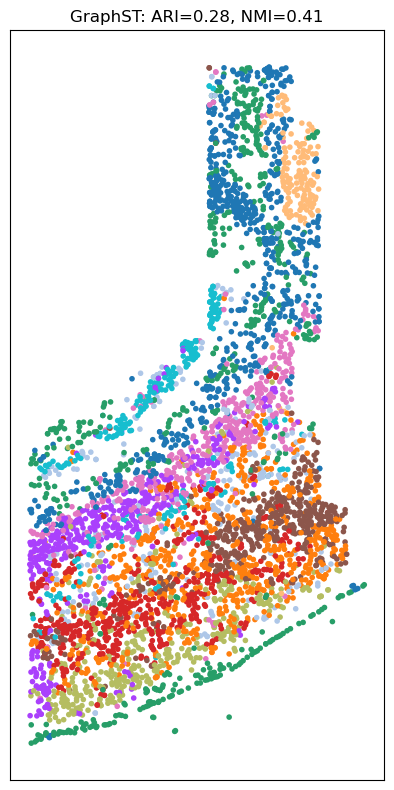

In [6]:
import matplotlib.pyplot as plt
sub_adata = adata[~pd.isnull(adata.obs['Region'])]
ARI = metrics.adjusted_rand_score(sub_adata.obs['Region'], sub_adata.obs['domain'])
NMI = metrics.normalized_mutual_info_score(sub_adata.obs['Region'], sub_adata.obs['domain'])
fig, ax = plt.subplots(1, 1, figsize=(6, 8))

sc.pl.spatial(adata, color='domain', ax=ax, show=False, spot_size=20, size=20, color_map='viridis',legend_loc=None)
# sc.pl.spatial(adata, color='domain', ax=ax, show=False, spot_size=20)
ax.set_title('GraphST: ARI=%.2f, NMI=%.2f' % (ARI, NMI))
ax.set_xlabel('')
ax.set_ylabel('')

output_dir = './GraphST_ARI_NMI'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
output_path = os.path.join(output_dir, "GraphST_osmfish_ARI.svg")
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

In [7]:
output_dir1 = ('../featrue/osmish')
if not os.path.exists(output_dir1):
    os.makedirs(output_dir1)
output_path = os.path.join(output_dir1, f"GraphST.h5ad")
adata.write_h5ad(output_path)

/data/hgh/anaconda3/envs/py310-torch25/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/data/hgh/anaconda3/envs/py310-torch25/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


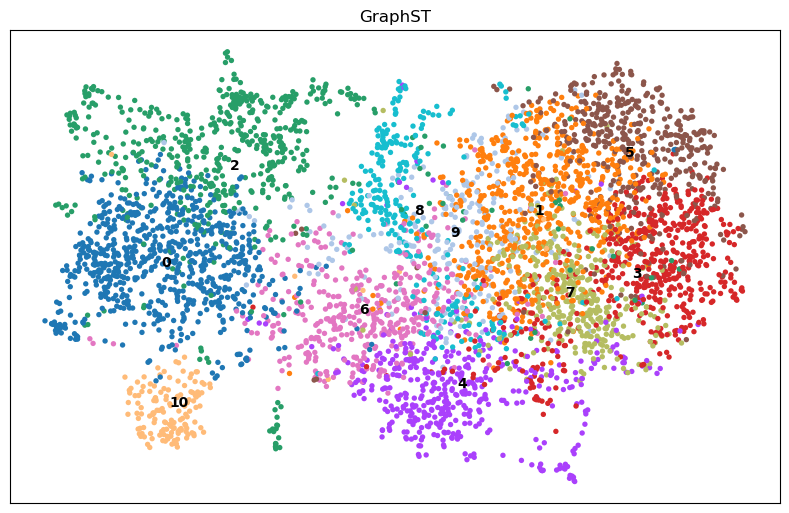

In [8]:
sc.pp.neighbors(adata, use_rep='emb', metric='cosine')
sc.tl.umap(adata, min_dist=0.2, spread=0.4)

fig, axes = plt.subplots(1, 1, figsize=(8, 8))
sc.pl.umap(adata, color='domain', ax=axes, show=False,size=60,legend_loc=None)

# 设置标题
axes.set_title('GraphST')
axes.set_aspect(1)

for cluster in adata.obs['domain'].unique():
    # 计算每个类别的 UMAP 中心点
    cluster_points = adata[adata.obs['domain'] == cluster].obsm['X_umap']
    x_mean, y_mean = cluster_points[:, 0].mean(), cluster_points[:, 1].mean()

    # 在中心点处添加标签
    axes.text(
        x=x_mean,  # X 坐标
        y=y_mean,  # Y 坐标
        s=cluster,  # 标签内容
        fontsize=10,
        ha='center',  # 水平对齐
        va='center',  # 垂直对齐
        color='black',  # 标签颜色
        fontweight='bold'  # 标签字体加粗
    )

axes.set_xlabel('')
axes.set_ylabel('')
plt.tight_layout()
output_path = os.path.join('./clustering_results', f"GraphST_osmfish.svg")
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()